# Travail pratique 4
*INF600F - Traitement d'images (A2024, UQÀM)*

* Vahid Foruzanmehr
* code permanent: forv26018703.
* Modifiez aussi le nom du notebook pour qu'il ait ce format : `TP4-Foruzanmehr`.

In [3]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

# Importation des modules pertinents ici.
# Assurez-vous d'inclure toute autre fonction que vous
# jugez nécessaires ici
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, square, white_tophat, disk
from skimage.measure import label, regionprops
from skimage.transform import resize

from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import io

# Exercice 1 : Reconnaissance de texte

In [5]:
def process_region(region, image_shape, background_removed_image):
    """
    Traite une région détectée pour extraire un caractère si elle est valide.

    Paramètres
    ----------
    region : skimage.measure._regionprops.RegionProperties
        Les propriétés de la région connectée.
    image_shape : tuple
        La forme de l'image d'origine (hauteur, largeur).
    background_removed_image : np.ndarray
        L'image où l'arrière-plan a été supprimé.

    Retours
    -------
    np.ndarray ou None
        Le caractère extrait et redimensionné à 24x24 pixels, ou None si la région est invalide.
    """
    minr, minc, maxr, maxc = region.bbox
    height, width = maxr - minr, maxc - minc

    # Filtrage des régions touchant les bords de l'image
    if minr == 0 or minc == 0 or maxr == image_shape[0] or maxc == image_shape[1]:
        return None

    # Filtrage des régions avec des dimensions non textuelles
    aspect_ratio = width / height
    if height < 10 or width < 10 or height > 100 or width > 80 or aspect_ratio < 0.2 or aspect_ratio > 1.5:
        return None

    # Ajouter une marge autour du caractère
    margin = 3
    minr = max(0, minr - margin)
    minc = max(0, minc - margin)
    maxr = min(image_shape[0], maxr + margin)
    maxc = min(image_shape[1], maxc + margin)

    # Extraire le caractère
    character = background_removed_image[minr:maxr, minc:maxc]

    # Redimensionner le caractère à 24x24 pixels
    resized_character = resize(character, (24, 24), preserve_range=True)
    return resized_character


In [6]:
def extract_characters(image: np.ndarray) -> list:
    """
    Fonction qui extrait les caractères d'une image de texte.

    Paramètres
    ----------
    image : np.ndarray
        Une image de texte en couleur.

    Retours
    -------
    list
        Une liste de np.ndarray, chacun représentant un caractère.
    """
    # Vérifier si l'image a un canal alpha (RGBA)
    if image.shape[-1] == 4:
        image = image[..., :3]

    # Conversion en niveaux de gris :
    # L'image couleur est convertie en niveaux de gris, ce qui simplifie
    # le traitement en réduisant l'information aux intensités lumineuses
    gray_image = rgb2gray(image)

    # Conversion en float et Normalisation des intensités:
    # Les valeurs des pixels sont converties en float et normalisées
    # entre 0 et 1.
    # Cela rend l'image uniforme en termes de plage d'intensités,
    # facilitant le traitement.
    gray_image = gray_image.astype(float)
    normalized_image = gray_image / np.max(gray_image)

    # Inversion des intensités:
    # Les couleurs sont inversées pour que les caractères deviennent des
    # zones lumineuses sur un fond sombre. Cela facilite la segmentation
    # ultérieure.
    inverted_image = 1.0 - normalized_image

    # Effacement de l'arrière-plan :
    # La méthode White Top-Hat est appliquée pour supprimer les grandes zones
    # d'arrière-plan et conserver les détails (comme les caractères).
    background_removed_image = white_tophat(inverted_image, footprint=disk(15))

    # Segmentation par seuillage global (Méthode d'Otsu) :
    # Un seuil global est calculé à l'aide de la méthode d'Otsu pour séparer
    # les pixels du texte (blancs) de l'arrière-plan (noirs).
    threshold = threshold_otsu(background_removed_image)
    binary_image = background_removed_image > threshold

    # Nettoyage avec fermeture morphologique :
    # Une fermeture morphologique (closing) est appliquée pour combler
    # les petits trous dans les caractères.
    cleaned_image = closing(binary_image, square(3))
    # Les petits objets (< 100 pixels) sont supprimés pour éliminer les
    # bruits non textuels.
    cleaned_image = remove_small_objects(cleaned_image, min_size=100)

    # Étiquetage des régions connectées :
    # Les régions connectées (caractères potentiels) sont détectées et étiquetées.
    # Chaque région est analysée pour extraire les informations sur son
    # emplacement et ses dimensions.
    labeled_image = label(cleaned_image)
    regions = regionprops(labeled_image)

    # Extraction des caractères avec filtrage :

    characters = []
    for region in regions:
        character = process_region(region, gray_image.shape, background_removed_image)
        if character is not None:
            characters.append(character)

    # La fonction retourne une liste d'images (np.ndarray), chacune
    # représentant un caractère extrait.
    return characters


In [7]:
import random

def display_randomImages(characters: list) -> None:
    """
    Fonction qui affiche des caractères aléatoires.

    Paramètres
    ----------
    characters : list
        Une liste de np.ndarray, chacun représentant un caractère.
    """
    if not characters:
        print("Aucun caractère à afficher.")
        return

    num_to_display = min(12, len(characters))
    random_characters = random.sample(characters, num_to_display)

    fig, axes = plt.subplots(1, num_to_display, figsize=(15, 5))
    for ax, char in zip(axes, random_characters):

        ax.imshow(-1 * char, cmap='gray')
        ax.axis('off')
    plt.show()


In [8]:
# Ajouter ici des cellules de code / markdown pour vos réponses

In [9]:
img1 = imageio.imread('tp4_ex1.png')

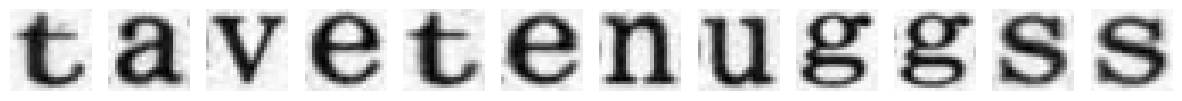

In [10]:
characters = extract_characters(img1)

display_randomImages( characters)

### Combien de lettres avez-vous détectées dans cette image ?

In [12]:
print(f'{len(characters)} lettres détectées dans cette image')

562 lettres détectées dans cette image


### plus haut échoue à extraire une lettre isolée ?



1.   **Lettres avec des parties séparées (comme le 'i') :**
Le pipeline détecte parfois des points ou des accents (comme le point du 'i' ou l'accent d'un 'é') comme des lettres distinctes. Cela est dû à la segmentation par régions connectées, qui considère chaque composante connectée comme une région indépendante.

2.   **Lettres très proches fusionnées en une seule région :**
Lorsque deux lettres sont très proches ou légèrement connectées (par exemple, dans un texte manuscrit ou une police condensée), le pipeline peut les considérer comme une seule région connectée et ne segmenter qu'une lettre "fusionnée".

3. **Caractères multiples par région détectée :**
Parfois, une seule région détectée peut contenir plusieurs caractères si ces derniers sont très proches ou connectés par des traits ou des courbes.

4. (pas pour cette image) **Problèmes liés aux variations d'intensité ou à un contraste insuffisant :**
Dans certains cas, si l'image a un contraste faible ou des artefacts d'arrière-plan, la méthode de seuillage peut ne pas bien séparer les caractères du fond, conduisant à une mauvaise segmentation.

5. (pas pour cette image) **Supprimer des lettres valides qui touchent par inadvertance les bords**

### Que suggérez-vous pour améliorer les performances de l’extraction des lettres ?

1. **Gestion des lettres avec des parties séparées :**
  * Appliquer une analyse de regroupement (clustering) pour associer les composants séparés d'une même lettre (par exemple, associer le point du 'i' à son corps principal).
  * Intégrer des heuristiques basées sur la proximité ou l'alignement vertical des composants.

2. **Améliorer la segmentation des lettres très proches :**
  * Affiner les paramètres de fermeture morphologique pour mieux séparer les lettres.
  * Utiliser des techniques de séparation basée sur des crêtes ou watershed algorithm.

3. **Affiner les critères de filtrage :**
  * Ajuster les seuils de taille et de rapport d'aspect pour éviter de rejeter des lettres valides.
  * Intégrer des modèles basés sur l'apprentissage profond pour reconnaître les formes de lettres, ce qui pourrait remplacer les simples règles de taille et de forme.

# Partie 2 : Partitionnement non supervisé des lettres

In [18]:
def extract_hog_features(images):
    """
    Extrait les descripteurs HOG pour une liste d'images.

    Paramètres
    ----------
    images : list of np.ndarray
        Liste d'images normalisées (par ex., 24x24).

    Retours
    -------
    np.ndarray
        Matrice des descripteurs HOG de taille (nImages x nCaractéristiques).
    """
    hog_features = []
    for image in images:
        # Calcul des descripteurs HOG
        feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

In [19]:
def kmeans_partitioning(hog_features, n_clusters=26):
    """
    Effectue le partitionnement K-means sur les descripteurs HOG.

    Paramètres
    ----------
    hog_features : np.ndarray
        Matrice des descripteurs HOG.
    n_clusters : int
        Nombre de clusters pour le partitionnement.

    Retours
    -------
    KMeans
        Modèle K-means entraîné.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(hog_features)
    return kmeans

In [20]:
def visualize_clusters(kmeans, images, n_clusters=26):
    """
    Visualise les clusters et les images moyennes par classe.

    Paramètres
    ----------
    kmeans : KMeans
        Modèle K-means entraîné.
    images : list of np.ndarray
        Liste d'images associées.
    n_clusters : int
        Nombre de clusters.
    """
    labels = kmeans.labels_
    fig, axes = plt.subplots(n_clusters, 10, figsize=(15, 20))

    for cluster in range(n_clusters):
        # Images dans le cluster courant
        cluster_images = [images[i] for i in range(len(images)) if labels[i] == cluster]

        # Afficher les premières images du cluster
        for idx, img in enumerate(cluster_images[:10]):
            axes[cluster, idx].imshow(img, cmap='gray')
            axes[cluster, idx].axis('off')

        # Calculer l'image moyenne du cluster
        if cluster_images:
            mean_image = np.mean(cluster_images, axis=0)
            axes[cluster, 0].imshow(mean_image, cmap='gray')
            axes[cluster, 0].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

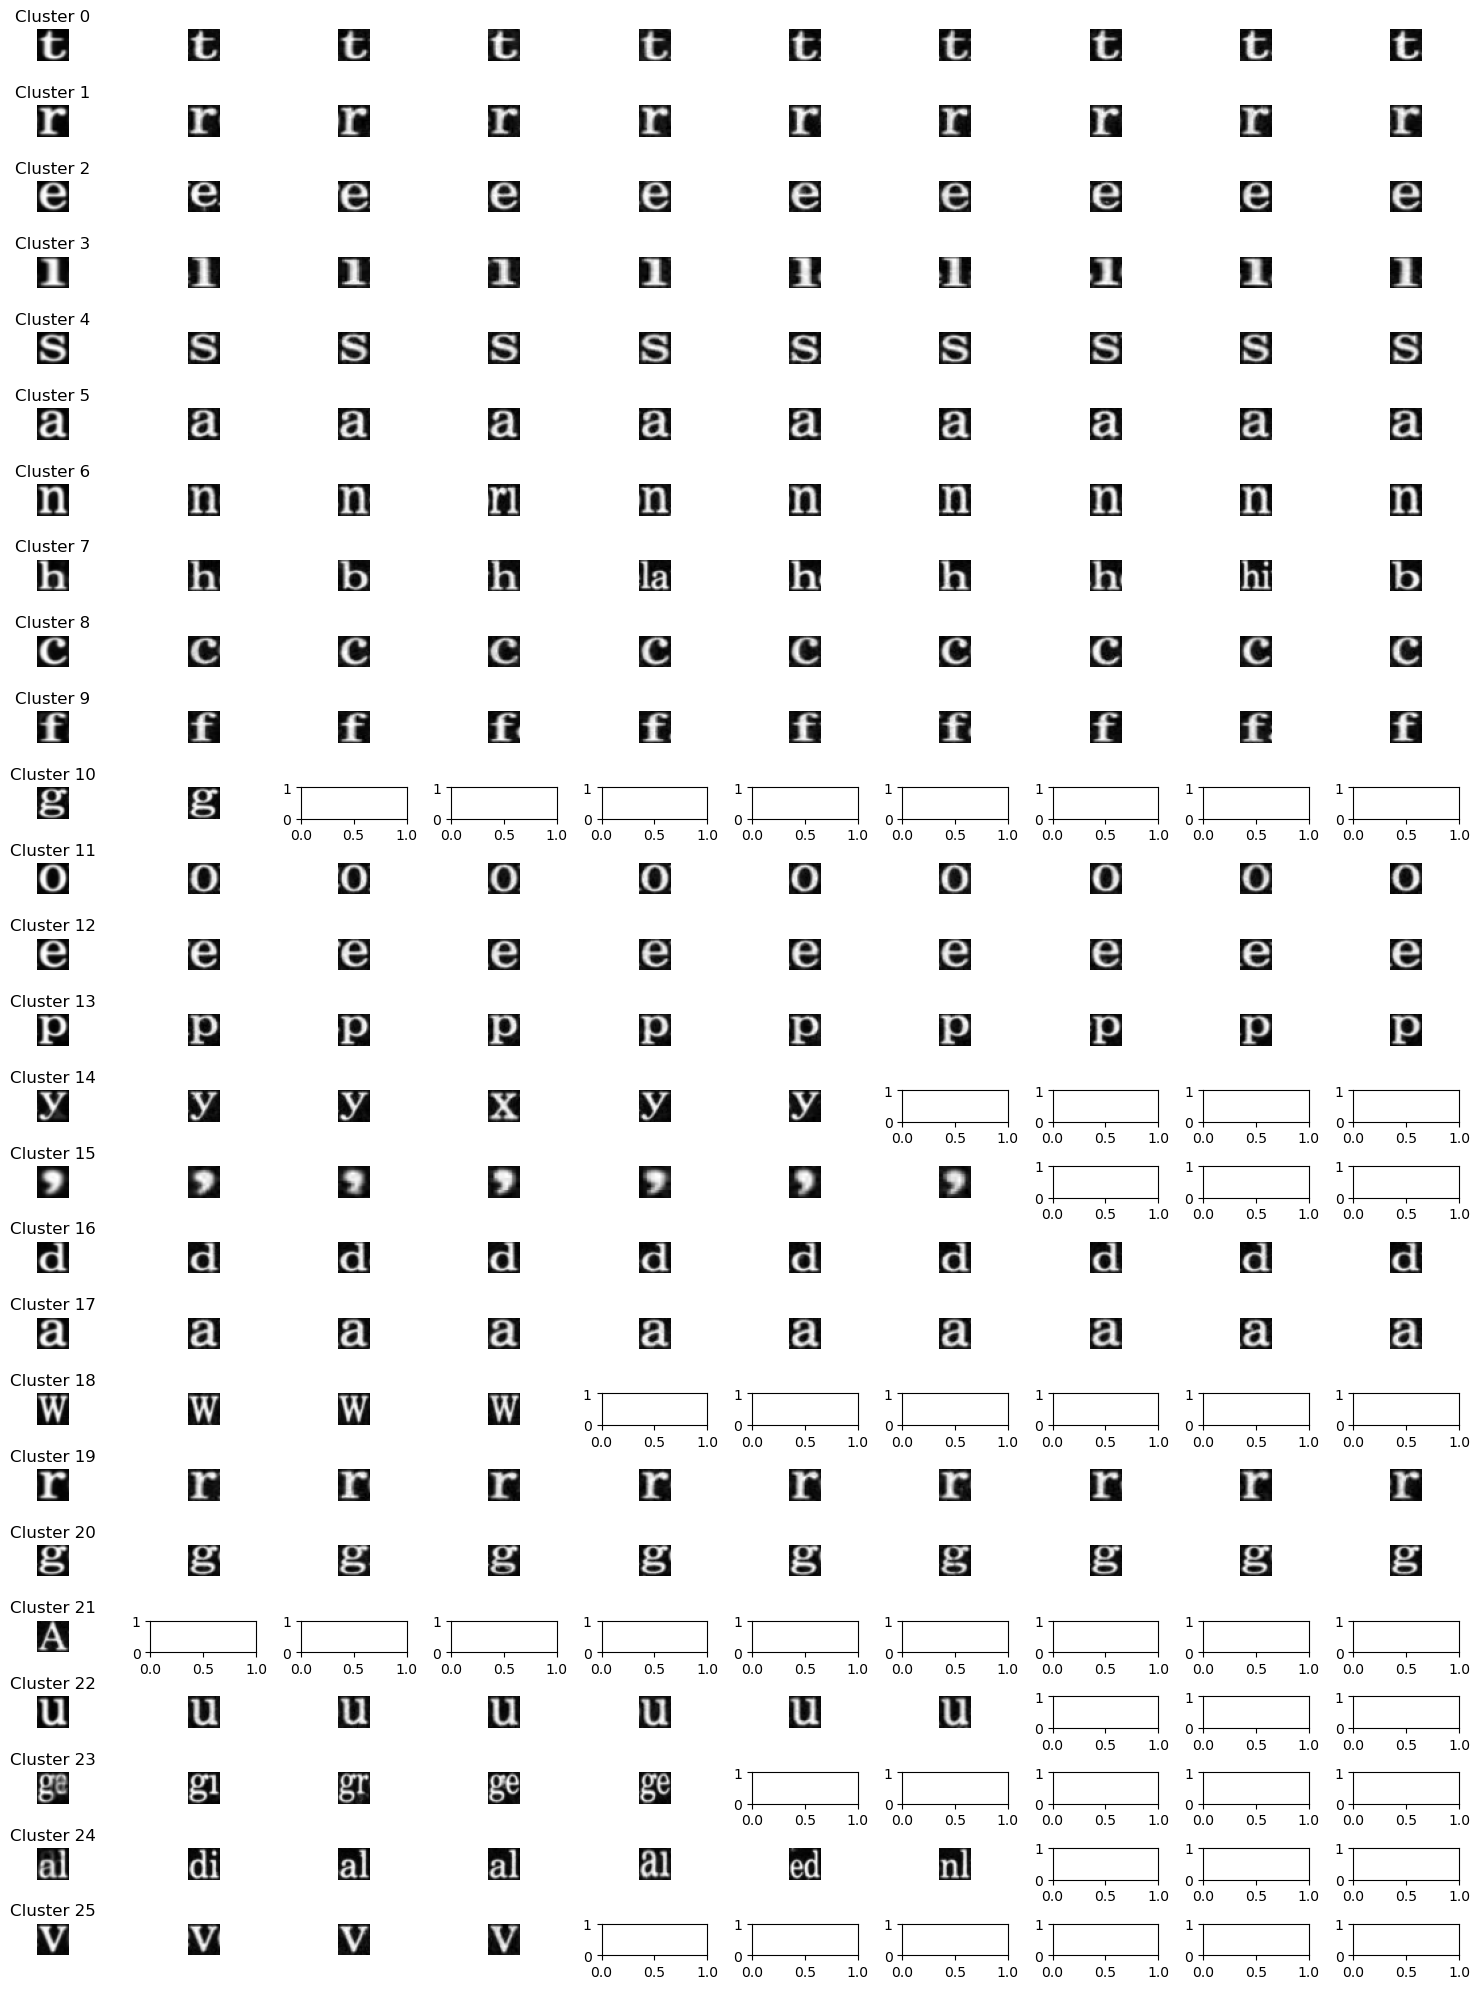

In [21]:
# Étape 1 : Extraire les descripteurs HOG
hog_features = extract_hog_features(characters)

# Étape 2 : Effectuer le partitionnement avec K-means
kmeans = kmeans_partitioning(hog_features, n_clusters=26)

# Étape 3 : Visualiser les clusters
visualize_clusters(kmeans, characters, n_clusters=26)

### Observations principales

* Clusters corrects :

Plusieurs clusters regroupent efficacement des lettres similaires, comme :
1. Cluster h est bien regroupé plusieurs fois.
2. Cluster f est isolé avec cohérence.
3. Cluster g est dominant dans ce cluster.
4. Cluster e est correctement regroupé.
5. Cluster w est identifié clairement.

Ces résultats montrent que les descripteurs HOG capturent efficacement les structures et contours des lettres, ce qui permet de former des groupes cohérents pour les lettres visuellement similaires.

* Clusters mixtes :

Certains clusters contiennent des lettres différentes, ce qui suggère une certaine confusion dans le partitionnement :
1. Cluster y: Contient principalement y mais une lettre x apparaît également.
2. Cluster des lettres comme al, ed, nl, et d'autres formes composites ou incorrectement segmentées.
3. Cluster des lettres telles que u, g, et ge, indiquant une confusion dans la détection.


* Cette confusion pourrait être due à plusieurs raisons :

1. Similitude visuelle : Certaines lettres ont des contours similaires (comme y et x ou u et n).
2. Erreur de segmentation : Les lettres mal segmentées (comme des lettres composites ge ou nl) compliquent l'analyse.
3. Variations d'intensité ou de forme : Les lettres peuvent avoir des variations dues à des styles de police différents.

#### Conclusion:

Les résultats montrent que K-means avec des descripteurs HOG est capable de regrouper efficacement plusieurs lettres similaires, comme les h, f, g, et e. Cependant, des erreurs apparaissent dans les clusters contenant des lettres composites ou visuellement similaires. L'amélioration de la segmentation initiale et l'utilisation de techniques plus sophistiquées permettraient d'obtenir des résultats plus précis et cohérents.

# Exercice 2 : Compter des cellules

In [25]:
# Ajouter ici des cellules de code / markdown pour vos réponses

In [26]:
img2 = imageio.imread('tp4_ex2.tif')

In [27]:
def count_cells(image: np.ndarray) -> int:
    """
    Fonction qui compte le nombre de cellules dans une image.

    Paramètres
    ----------
    image (np.ndarray): Une image d'un microscope contenant des cellules à dénombrer.

    Retours
    -------
    int: Le nombre de cellules dans l'image.
    """

    # Vérification et conversion en niveaux de gris
    if len(image.shape) == 3:
        if image.shape[2] == 4:
            image = image[:, :, :3]
        gray_image = rgb2gray(image)
    else:
        gray_image = image

    # Segmentation par seuillage global (Otsu):
    # Pour distinguer les cellules de l'arrière-plan.
    # La méthode d'Otsu calcule un seuil global optimal basé sur l'histogramme
    # des intensités de l'image.
    thresh = threshold_otsu(gray_image)
    binary_image = gray_image > thresh

    # Nettoyage morphologique:
    # Les cellules peuvent contenir de petits trous ou des interruptions dans leur structure.
    # L'arrière-plan peut contenir des artefacts indésirables.
    cleaned_image = closing(binary_image, square(3))

    # Étiquetage des régions connectées
    # Pour identifier chaque cellule individuellement en attribuant une
    # étiquette unique à chaque région connectée dans l'image binaire.
    labeled_image = label(cleaned_image)

    # compter des cellule:
    # Le nombre total de régions étiquetées correspond au nombre de cellules détectées.
    cell_count = len(regionprops(labeled_image))

    return cell_count


## Tester avec une sous image :

In [29]:
# tester avec une petite sous image pour compter le nombre de cellules manuellement.
img_crop = img2[0:180, 0:250]

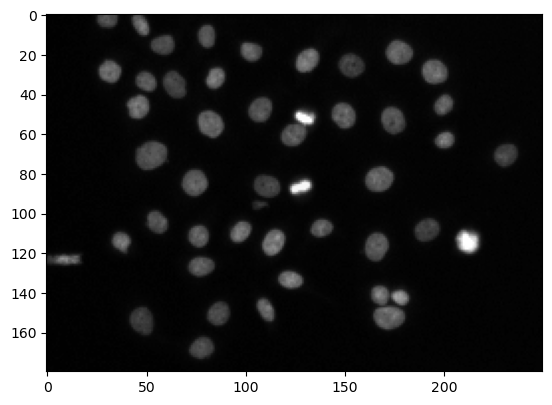

In [30]:
plt.imshow(img_crop, cmap='gray')

In [31]:
#
num_cells = count_cells(img_crop)
print(f"Nombre de cellules estimé : {num_cells}")


Nombre de cellules estimé : 45


## Tester avec visualization (Extra)

In [33]:
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries

def count_cells_with_visualization(image: np.ndarray) -> int:
    """
    Fonction qui compte le nombre de cellules dans une image et affiche les régions détectées.

    Paramètres
    ----------
    image (np.ndarray): Une image d'un microscope contenant des cellules à dénombrer.

    Retours
    -------
    int: Le nombre de cellules dans l'image.
    """

    if len(image.shape) == 3:
        if image.shape[2] == 4:
            image = image[:, :, :3]
        gray_image = rgb2gray(image)
    else:
        gray_image = image

    thresh = threshold_otsu(gray_image)
    binary_image = gray_image > thresh

    cleaned_image = closing(binary_image, square(3))

    labeled_image = label(cleaned_image)

    cell_count = len(regionprops(labeled_image))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("Image originale")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(image, labeled_image, color=(1, 0, 0)))  # Marque les frontières des cellules détectées
    ax[1].set_title(f"Régions détectées: {cell_count} cellules")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    return cell_count


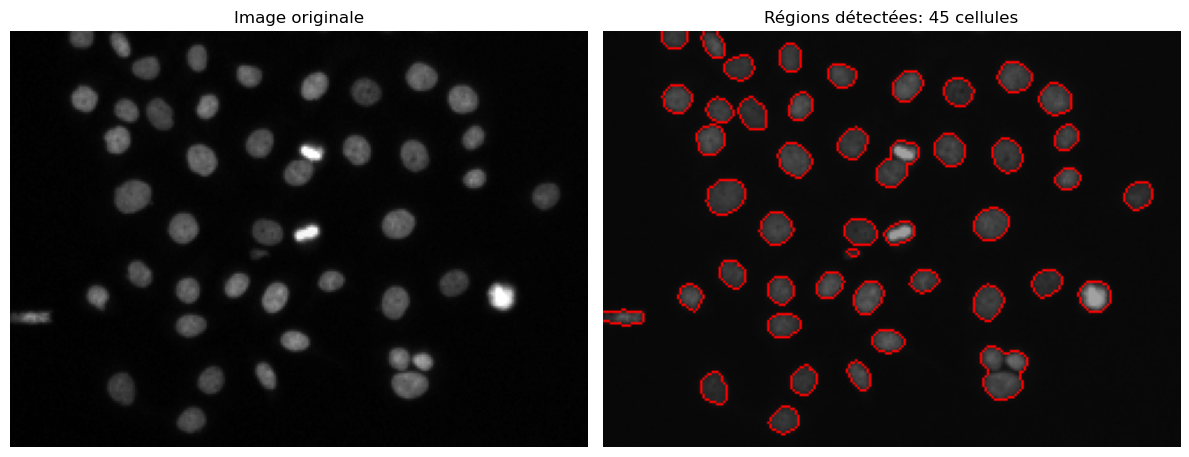

Nombre de cellules estimé : 45


In [34]:
num_cells = count_cells_with_visualization(img_crop)
print(f"Nombre de cellules estimé : {num_cells}")

## Compter des cellules d'image tp4_ex2.png

In [36]:
numbre_cells = count_cells(img2)
print(f"Nombre de cellules estimé : {numbre_cells}")

Nombre de cellules estimé : 267
